***
<div style="text-align:center">
     <h1 align="center">
         <i class="fas fa-calendar-day" aria-hidden="true">  Day 10 of #3D_vision_journey </i>
    </h1>      
</div>

<h3 style='text-align: center;'>
    <img  src="../images/open3d_logo.png" height="50"/>     
</h3>

* Load the libraries

In [1]:
import open3d as o3d
import numpy as np
import copy
import os
import sys
import matplotlib.pyplot as plt
import open3d_tutorial as o3dtut

draw_bit = 1 # draw it or not!

###  Load point cloud 

Load a point cloud , paint it gray, and render it


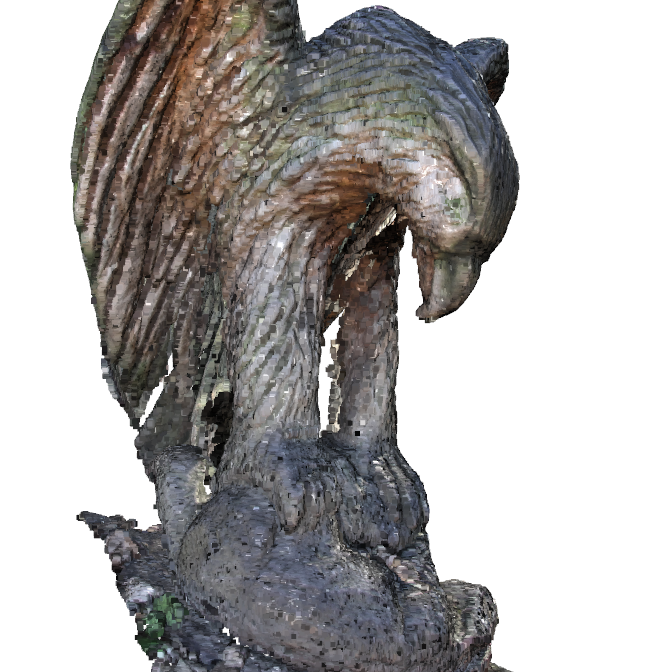

In [2]:
print("Load a point cloud , paint it gray, and render it")
# Read a point cloud from file  .xyz  .xyzn  .xyzrgb   .pts   .ply   .pcd
pcd = o3dtut.get_eagle_pcd()


if draw_bit:
    o3d.visualization.draw_geometries([pcd],
                                  zoom=0.564,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])


### Poisson surface reconstruction
* Poisson surface reconstruction will also create `triangles` in areas of `low point density`, 
    and even extrapolates into some areas

run Poisson surface reconstruction
[Open3D DEBUG] Input Points / Samples: 796825 / 368254
[Open3D DEBUG] #   Got kernel density: 0.133402 (s), 310.613 (MB) / 310.613 (MB) / 310 (MB)
[Open3D DEBUG] #     Got normal field: 0.541188 (s), 416.914 (MB) / 416.914 (MB) / 416 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 2.623551e-06 / 2.090511e+00
[Open3D DEBUG] #       Finalized tree: 0.57314 (s), 547.883 (MB) / 547.883 (MB) / 547 (MB)
[Open3D DEBUG] #  Set FEM constraints: 1.12402 (s), 508.312 (MB) / 547.883 (MB) / 547 (MB)
[Open3D DEBUG] #Set point constraints: 0.211655 (s), 508.312 (MB) / 547.883 (MB) / 547 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 2945433 / 3365000 / 1209
[Open3D DEBUG] Memory Usage: 508.312 MB
[Open3D DEBUG] # Linear system solved: 1.99602 (s), 547.75 (MB) / 547.883 (MB) / 547 (MB)
[Open3D DEBUG] Got average: 0.0527771 (s), 511.285 (MB) / 547.883 (MB) / 547 (MB)
[Open3D DEBUG] Iso-Value: 5.028479e-01 = 4.006817e+05 / 7.968250e+05
[Open3D DEBUG] #

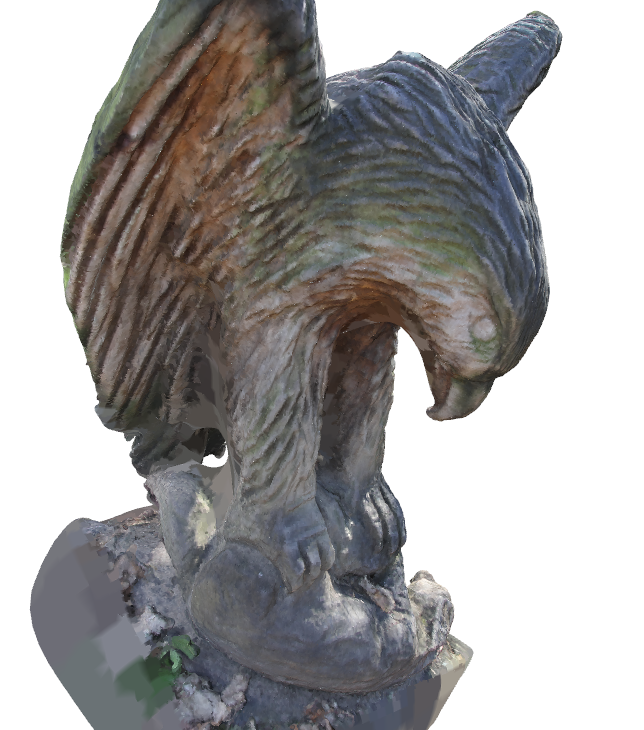

In [3]:
print('run Poisson surface reconstruction')

with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=9)

print("\nMesh:\n",mesh)
if draw_bit:
    o3d.visualization.draw_geometries([mesh],
                                  zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])

In [4]:
np.asarray(mesh.vertices).shape

(563112, 3)

### visualizing densities
>  `densities` return value that indicates for `each vertex (a node in the mesh) the density`. 

> A low density value means that the vertex is only supported by a low number of points from the input point cloud.

* `Violet` indicates `low density` and `yellow` indicates a `high density`.

Density Colors shape: (563112, 3)
same as the mesh vertices shape: (563112, 3)


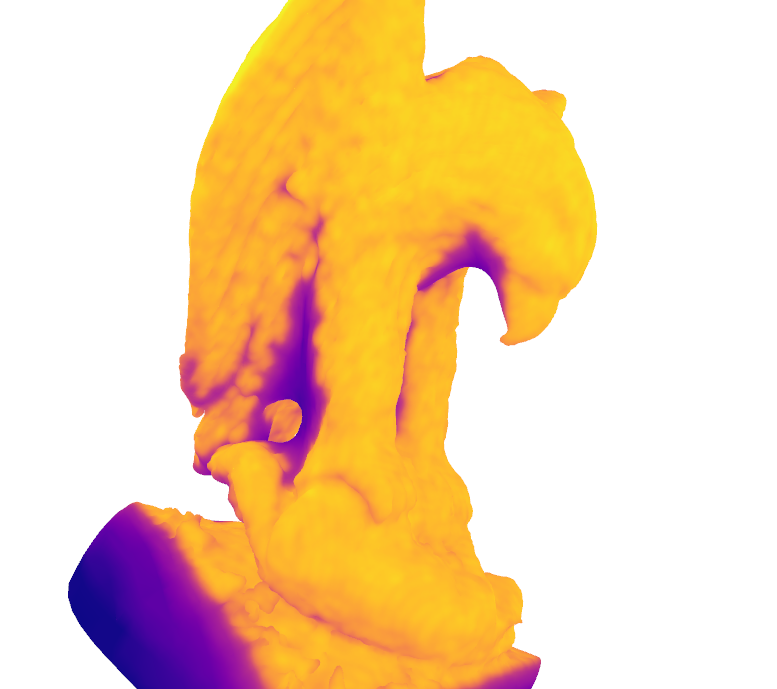

In [5]:

densities = np.asarray(densities)
# define density colors
normalized_densities = (densities - densities.min()) / (densities.max() - densities.min())
density_colors = plt.get_cmap('plasma')(normalized_densities)
density_colors = density_colors[:, :3]
print(f'Density Colors shape: {density_colors.shape}\nsame as the mesh vertices shape: {np.asarray(mesh.vertices).shape}')

# defining a new density mesh
density_mesh                  = o3d.geometry.TriangleMesh()
density_mesh.vertices         = mesh.vertices
density_mesh.triangles        = mesh.triangles
density_mesh.triangle_normals = mesh.triangle_normals
density_mesh.vertex_colors    = o3d.utility.Vector3dVector(density_colors)# np to 3d

if draw_bit:
    o3d.visualization.draw_geometries([density_mesh],
                                  zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])

### remove low density vertices
> Use the density values to remove vertices and triangles that have a low support.


remove low density vertices
TriangleMesh with 557480 points and 1113216 triangles.


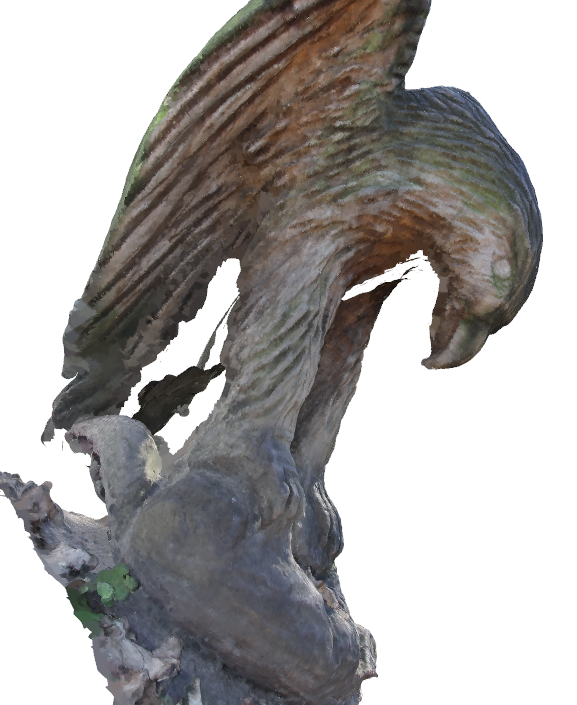

In [6]:
print('remove low density vertices')
vertices_to_remove = densities < np.quantile(densities, 0.01)
mesh.remove_vertices_by_mask(vertices_to_remove)
print(mesh)
o3d.visualization.draw_geometries([mesh],
                                  zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])